In [1]:
#poggers

# Распознавание жанра музыки #

## Постановка задачи

Решить задачу классификации музыкальных жанров с помощью свёрточной нейронной сети.

## Исходные данные

Исходные данные представлены в виде датасета, состоящего из тысячи тридцатисекундных музыкальных композиций. Каждый трек представляет один из десяти жанров, которые присутствуют в датасете.

Этот датасет будет поделён на обучающую и тестовую выборки: в первой будет по 90 композиций каждого жанра, а во второй - 10.

Список музыкальных жанров: блюз, классика, кантри, диско, хипхоп, джаз, метал, поп, регги, рок.

## Содержание

1. Описание и подготовка данных
2. Построение модели
3. Обучение модели
4. Выводы

In [2]:
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import os
import sys
import warnings

In [3]:
!nvidia-smi

Mon Apr 26 12:00:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   38C    P0    55W / 300W |  27792MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   34C    P0    57W / 300W |   4207MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Анализ и подготовка данных

Этот датасет уже был использован в работе двух исследователей: Джорджа Тзанетакиса и Перри Кука. Их публикацию 2002-ого года можно найти [здесь](https://www.researchgate.net/publication/3333877_Musical_Genre_Classification_of_Audio_Signals).

Стоит отметить, что из этой работы была извлечена полезная информация, позволяющая определить путь решения поставленной в нашей работе задачи.

Сам датасет был составлен с упором на некоммерчерское использование: музыкальные композиции в нём даже не имеют закреплённых названий и исполнителей, под которыми они распространялись, соответственно, речи об авторских правах нет. Музыка была извлечена из множества случайных компакт-дисков начала 2000-х, записана с радио вещаний или взята в музыкальных студиях и вручную была рассортирована.

Каждая из тысячи композиций идёт ровно 30 секунд, записана с частотой 22,05 КГц в 16 бит и в моно канале, в формате .wav. С представленными в таком виде данными намного легче работать, плюс ко всему, современное аудио можно легко преобразовать к таким характеристикам, обьединив каналы и понизив частоту.

Для начала необходимо определить, в каком виде необходимо представить данные для нейросети и какие преобразования необходимы. Для работы с аудиофайлами будем использовать библиотеку `Librosa`.

In [4]:
# Считываем файл с ссылочками на музыку и с соответствующими ссылкам жанрами
data_src = pd.read_csv("meta.csv", sep=";")
data_src.loc[500:510]

genre                                               path
500  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
501  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
502  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
503  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
504  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
505  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
506  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
507  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
508  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
509  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...
510  jazz  /zfs/store5.hydra.local/user/d/danand/tutor_po...

In [5]:
# Анализируем, смотрим графики для всех жанров:
genres = []
for i in range(10):
    ti = i * 100
    tfn = data_src.loc[ti][0]
    genres.append(tfn)
print(genres)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Имеет смысл просмотреть спектрограммы для всех жанров и оценить, можно ли вообще выделить характеристики для классификации нейросетью.

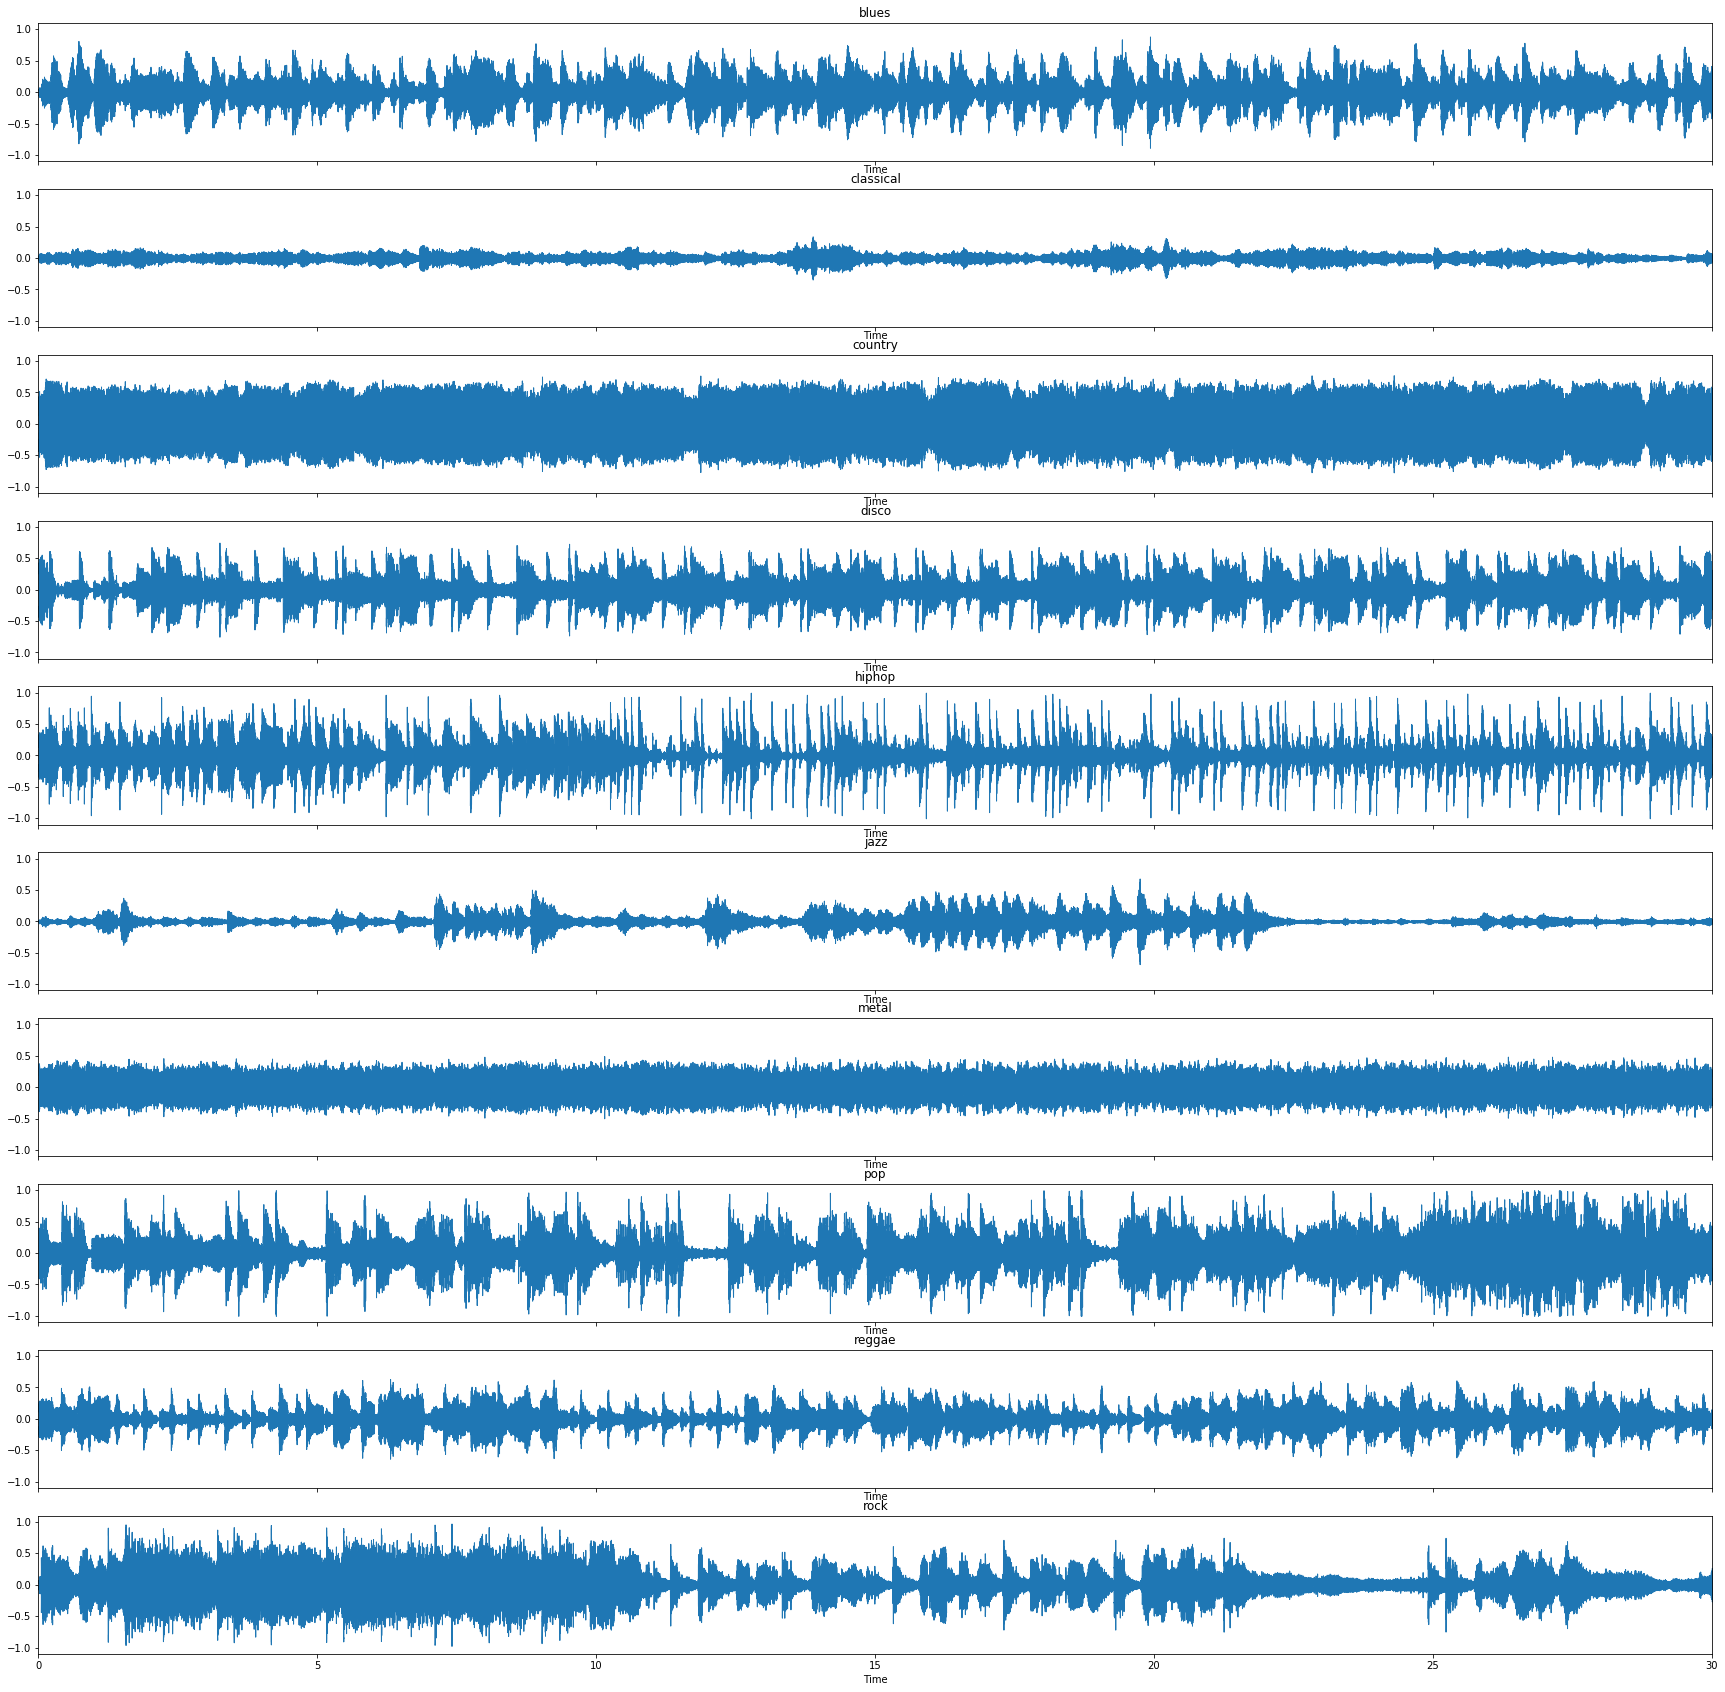

In [6]:
fig, ax = plt.subplots(nrows=10, sharex=True, sharey=True, figsize=(30,30))
for i in range(10):
    fn = data_src.loc[i * 100][1]
    data, sampling_rate = librosa.load(fn)
    ax[i].set_title(genres[i])
    librosa.display.waveplot(data, sr=sampling_rate, ax=ax[i])

In [7]:
# Перемешиваем датафрейм и проверяем результат:
# причём так, чтобы заново сгенерировать индексы, иначе не сможем обращаться к Serial-элементам корректно
data_src = data_src.sample(frac=1).reset_index(drop=True)
data_src[500:510]

genre                                               path
500     hiphop  /zfs/store5.hydra.local/user/d/danand/tutor_po...
501      metal  /zfs/store5.hydra.local/user/d/danand/tutor_po...
502       rock  /zfs/store5.hydra.local/user/d/danand/tutor_po...
503      blues  /zfs/store5.hydra.local/user/d/danand/tutor_po...
504      metal  /zfs/store5.hydra.local/user/d/danand/tutor_po...
505     reggae  /zfs/store5.hydra.local/user/d/danand/tutor_po...
506      blues  /zfs/store5.hydra.local/user/d/danand/tutor_po...
507  classical  /zfs/store5.hydra.local/user/d/danand/tutor_po...
508     hiphop  /zfs/store5.hydra.local/user/d/danand/tutor_po...
509       rock  /zfs/store5.hydra.local/user/d/danand/tutor_po...

In [8]:
# Формируем входные данные для тестовой и валидационной выборок
input_data = []
for i in range(1000):
    fn = data_src.loc[i][1]
    data, sampling_rate = librosa.load(fn)
    input_data.append(data.tolist())

In [9]:
# Выясняем минимальную длину массива, входные данные должны быть фиксированной длины
minl = 700000
idx = -1
for i in range(1000):
    if len(input_data[i]) < minl:
        minl = len(input_data[i])
        idx = i
print(minl, idx)

660000 37


In [10]:
# Обрезаем все массивы с минимальными потерями для данных
for i in range(1000):
    input_data[i] = input_data[i][:minl]

blues


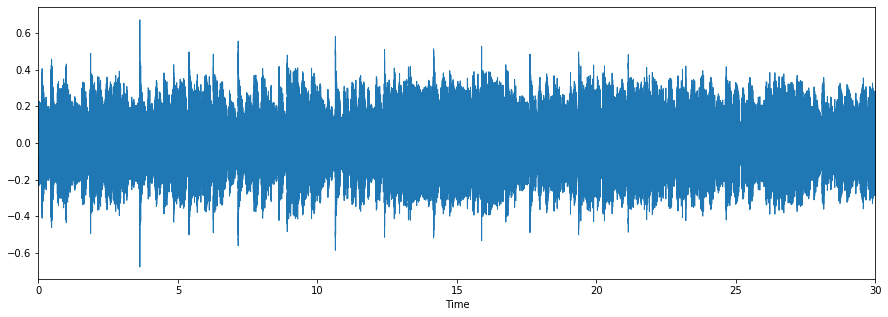

In [11]:
# Проверка
trackn = 521
fn = data_src.loc[trackn][1]
data, sampling_rate = librosa.load(fn)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
print(data_src.loc[trackn][0])
ipd.Audio(fn)

## Векторизуем валидационные данные для нейросети:

In [12]:
# Преобразуем жанры треков в номера, которые соответствуют номеру жанра в массиве genres
output_data = []
for i in range(1000):
    curg = data_src.loc[i][0]
    output_data.append(genres.index(curg))
output_data[500:510] # сравниваем с выводами выше и понимаем, что всё ОК

[4, 6, 9, 0, 6, 8, 0, 1, 4, 9]

In [13]:
# Векторизуем данные с помощью keras
from tensorflow.keras.utils import to_categorical
num_classes = 10
fout = to_categorical(output_data, num_classes)
fout[500:510] # сравниваем с выводами выше и понимаем, что всё ОК

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## А теперь делим данные на тестовую и валидационную

Так как датасет однородный и не содержит такие семплы, которые бы будучи в валидационной выборке смогли выдать необходимые для формализованных задач характеристики, мы можем просто поделить перемешанный датасет в нужной нам пропорции и не думать о том, какие семплы куда попали. (В данном случае: 9 к 1)

In [14]:
split_pointer = int((1000 / 10) * 9)
x_train, x_test = input_data[:split_pointer], input_data[split_pointer:]
print(len(x_train), len(x_test))
y_train, y_test = fout[:split_pointer], fout[split_pointer:]
print(len(y_train), len(y_test))

900 100
900 100


In [15]:
# Проверим, какой вид имеют данные
for sample_num in range(10):
    print(sample_num, "-", x_train[sample_num][300000:300010], "\n",
          "max:" ,max(x_train[sample_num]), "min:", min(x_train[sample_num]))

0 - [-0.1416015625, -0.129425048828125, -0.08294677734375, -0.06634521484375, -0.087371826171875, -0.16998291015625, -0.22357177734375, -0.197235107421875, -0.146728515625, -0.08831787109375] 
 max: 0.53533935546875 min: -0.506591796875
1 - [0.00836181640625, 0.0023193359375, -0.003631591796875, 0.001800537109375, -0.003173828125, -0.002288818359375, -0.00738525390625, -0.013885498046875, -0.014129638671875, -0.01287841796875] 
 max: 0.681427001953125 min: -0.576171875
2 - [-0.10491943359375, -0.08721923828125, -0.048431396484375, -0.03961181640625, 0.00689697265625, 0.04510498046875, 0.08367919921875, 0.1033935546875, 0.126007080078125, 0.122772216796875] 
 max: 0.869415283203125 min: -0.787811279296875
3 - [-0.428741455078125, -0.310546875, -0.131500244140625, -0.03387451171875, -0.056732177734375, -0.0665283203125, -0.08514404296875, -0.186798095703125, -0.282989501953125, -0.36932373046875] 
 max: 0.760986328125 min: -0.79827880859375
4 - [-0.0946044921875, -0.12030029296875, -0.11

Изучив данные, которые подаются на вход нейронной сети, можно сделать вывод, что нормирование не требуется. Так же, более понятна картина тех возможных функций активации, которые мы можем использовать в архитектуре сети.

Теперь осталось только перевести данные в массив библиотеки numpy:

In [16]:
# оно долго работает, аккуратно
x_train2 = np.array(x_train)
y_train2 = np.array(y_train)
x_test2 = np.array(x_test)
y_test2 = np.array(y_test)

In [17]:
x_train3 = np.expand_dims(x_train2, axis=2)
x_test3 = np.expand_dims(x_test2, axis=2)
print(len(x_train3[0]), len(y_train2[0]), "-", len(x_test3[0]), len(y_test2[0]))

660000 10 - 660000 10


In [18]:
# обрезаем данные для ускорения обучения
newlen = 10000
x_train4 = []
x_test4 = []
for i in range(900):
    x_train4.append(x_train[i][:newlen])
    
for i in range(100):
    x_test4.append(x_test[i][:newlen])

x_train5 = np.array(x_train4, dtype=float)
x_test5 = np.array(x_test4, dtype=float)

print(len(x_train5), len(y_train2), "-", len(x_test5), len(y_test2))
print(len(x_train5[0]), len(y_train2[0]), "-", len(x_test5[0]), len(y_test2[0]))
print(x_train5.shape, y_train2.shape, "-", x_test5.shape, y_test2.shape)

900 900 - 100 100
10000 10 - 10000 10
(900, 10000) (900, 10) - (100, 10000) (100, 10)


In [19]:
x_train6 = np.expand_dims(x_train5, axis=2)
x_test6 = np.expand_dims(x_test5, axis=2)
print(x_train6.shape, y_train2.shape, "-", x_test6.shape, y_test2.shape)

(900, 10000, 1) (900, 10) - (100, 10000, 1) (100, 10)


## Проблема: слишком большое количество данных

Как можно заметить, `количество данных даже при тотальной их обрезке слишком большое и необходим способ их преобразования: сжатия и выделения признаков.`

На текущий момент одним из наиболее рациональных выходов является метод мел-частотных кепстральных коэффициентов, который широко применяется для составления характеристик речевых сигналов и получил широкое распространение в сфере задач распознавания речи. `Данная метрика оценки звука больше приближена к тому, как человек оценивает музыкальную композицию на слух, так как мы воспринимаем высоту звука в определённый момент времени, а не данные о частотах, которые являются основой спектрограмм.`

blues


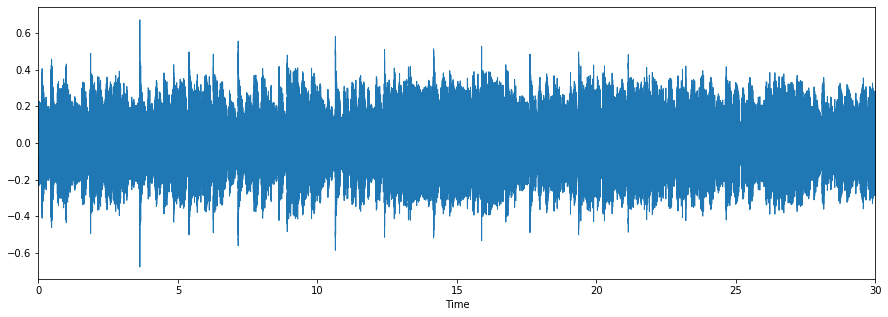

In [20]:
# Проверка
trackn = 521
fn = data_src.loc[trackn][1]
data, srate = librosa.load(fn)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=srate)
print(data_src.loc[trackn][0])
ipd.Audio(fn)

16 1293


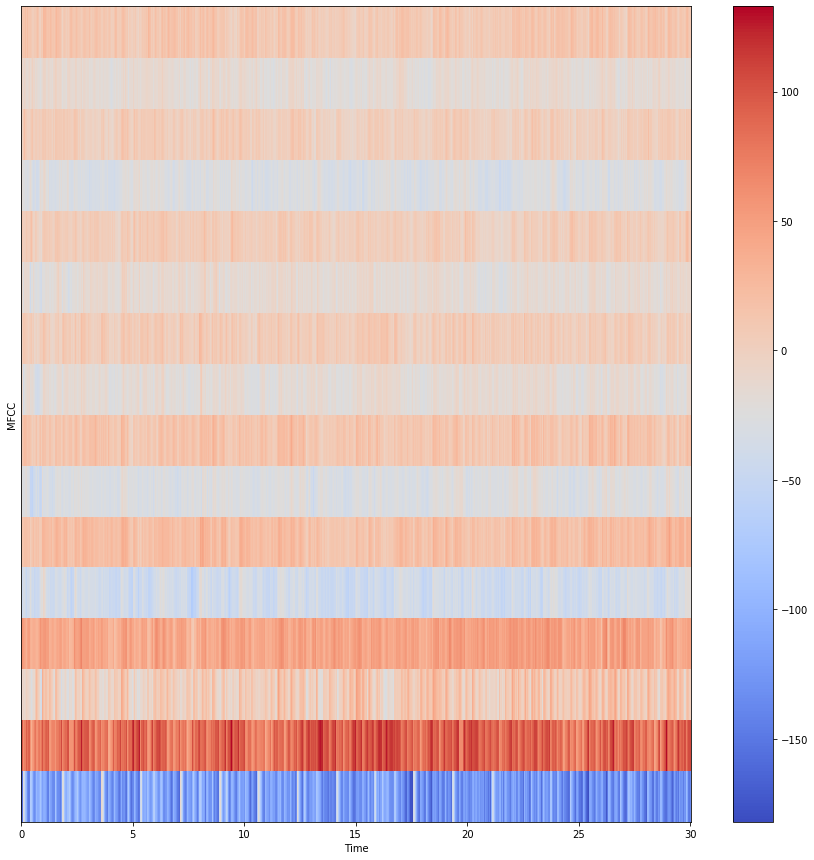

In [21]:
mfcc = librosa.feature.mfcc(y=data, sr=srate, n_mfcc=16)
plt.figure(figsize=(15, 15))
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
print(len(mfcc), len(mfcc[0]))

In [22]:
print(mfcc[0], "\n", mfcc[1], "\n", mfcc[2], "\n", mfcc[3])

[-146.73914 -148.77979 -157.51419 ... -154.72746 -150.64812 -137.3191 ] 
 [ 89.28439   91.87418   95.52275  ... 105.206436 105.33645  108.11446 ] 
 [  8.392071    0.6286224 -11.282656  ...   9.11638     3.2017384
   3.5730963] 
 [54.46839  57.87415  62.49451  ... 51.07903  47.900276 47.639183]


Опираясь на вид тех данных, которые получаюся при применении метода мел-частотных кепстральных коэффициентов, можно попробовать провести эксперимент и `использовать в качестве входных данных средние значения всех диапазонов.`

## Код ниже будет выполняться особенно долго, аккуратно

In [23]:
# Используем уже перемешанный список ссылок на треки
ex_input_data = []
for i in range(1000):
    curt = data_src.loc[i][1]                                  # Получаем ссылку
    data, srate = librosa.load(curt)                           # Получаем данные для MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=srate, n_mfcc=128)  # Получаем коэффициенты
    mfccr = []
    for i in range(128):                                       # Бегаем по массивам амплитуд спектра
        mfc = mfcc[i].mean()                                   # Получаем среднее из всех значений в текущем массиве
        mfccr.append(mfc)                                      # Дополняем временный массив
    ex_input_data.append(mfccr)                                # В результирующий массив кладем массив со средними значениями
print(ex_input_data[500])

[-109.48845, 97.372986, -20.622847, 37.36312, -3.1089725, 28.598396, -14.16002, 23.8397, -8.729605, 19.891531, -11.281407, 17.932617, -3.4677637, 8.230629, -8.941114, 9.266077, -4.982391, 1.8441542, -2.2397444, 0.67028064, 0.35413995, 5.1625943, 2.058409, 2.1712482, 0.27138197, -0.98429835, 1.2030979, 0.121818475, 0.8819294, 0.07719977, 0.25809616, -1.5940908, 2.6529899, 0.46879098, 1.1313703, -0.4672353, 1.2611777, -1.3619959, 1.3664707, -1.447774, 0.41448054, -0.20200886, 1.589791, -0.48380473, -0.18710735, -3.026944, -0.7441734, -2.1470268, -1.550996, -1.8529061, 0.47840676, 0.14414306, 2.4211395, 0.9256139, -0.6714752, -2.102786, -2.8863692, -1.288584, 0.40499115, 0.8619819, -0.50515723, -1.2509465, 0.38686216, 0.100377604, -0.8522377, -0.30451262, -0.3746264, -1.4359543, -0.9062315, -0.15783755, -1.7737954, -2.8551557, -2.583026, -2.6578448, -0.7937278, 1.8854637, 1.1315941, 1.8278754, 0.71614355, 0.7541037, -0.6108576, -1.0709401, -1.3818135, 0.48328188, -0.83657044, 0.104024515,

Ниже приводим данные к виду, необходимому для работы с нейросетью (Деление на тестовую и обучающую выборки, приведение к массиву nupy и приращение измерения). Очевидно, что значения класса преобразовывать не надо, ведь мы просто изменили представление исходных данных. Процесс выделения признаков каждого класса нейросетью зависит от применённого нами метода.

In [24]:
split_pointer = int((1000 / 10) * 9)
ex_train, ex_test = ex_input_data[:split_pointer], ex_input_data[split_pointer:]
print(len(ex_train), len(ex_test))

900 100


In [25]:
ex_train2 = np.array(ex_train)
ex_test2 = np.array(ex_test)

In [26]:
ex_train3 = np.expand_dims(ex_train2, axis=2)
ex_test3 = np.expand_dims(ex_test2, axis=2)
print(len(ex_train3[0]), len(y_train2[0]), "-", len(ex_test3[0]), len(y_test2[0]))

128 10 - 128 10


Как мы видим, мы смогли ощутимо сократить данные. На самом деле, цифры и само использование метода - не более, чем эксперимент, наиболее прочные обоснования того или иного шага можно найти в статье, ссылка на которую располагалась выше, сейчас мы почти буквально идём по следам её авторов.

# Построение модели

Главной особенностью данной модели является использование LSTM - долгой краткосрочной памяти. Это особая разновидность архитектуры рекурентных нейронных сетей, которая используется в задачах, связанных с распознаванием речи или звука.

Преимущество RNN состоит в том, что они умеют использовать предыдущую информацию с текущей задачей, но в целом нельзя сказать, что эта память долговременная. Модификация LSTM призвана убрать этот недостаток и позволяет нейросети обучиться долговренной зависимости. Обычная RNN может надолго запомнить какой-либо признак, но этого она добьется только через большое количество эпох, в то время, как для LSTM - это обычное дело

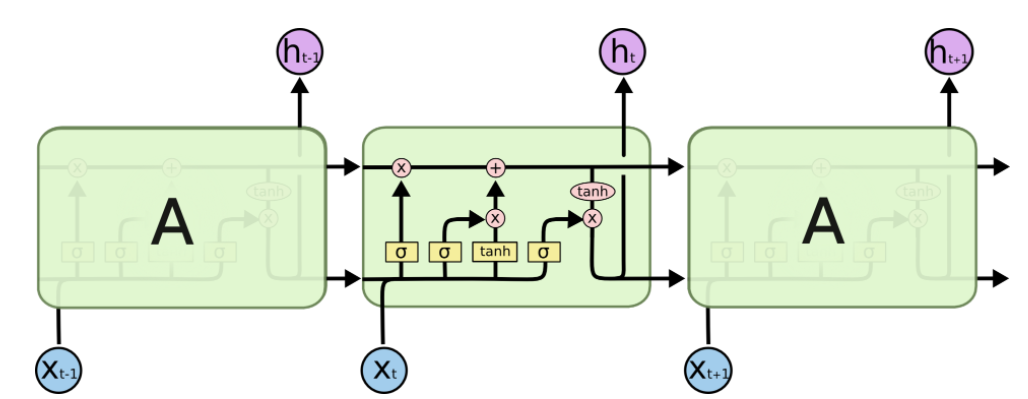

Если говорить коротко, то в данном случае слой LSTM представляет из себя повторяющиеся модули нейронной сети. Модули состоят из четырёх взаимодействующих друг с другом слоёв, и основной идеей долгой краткосрочной памяти является горизонтальная лента - `состояние ячейки`, которое проходит сквозь все модули сверху.

Каждый модуль может влиять на информацию, которая проходит сквозь все повторяющиеся фрагменты с помощью специальных фильтров, называемых `вратами`.

По сути, работу каждого фрагмента в слое LSTM можно описать тремя следующими пунктами:
1. Фрагмент определяет, какую информацию можно выбросить из состояния ячейки;
2. Фрагмент решает, какая информация будет храниться в состоянии ячейки;
3. Фрагмент решает, какого рода информация будет находиться на выходе и пойдёт на вход следующего фрагмента;

Все эти решения осуществляются в ходе работы фильтров, которые, если опираться на изображение выше, срабатывают слева направо.

In [38]:
# UDP(спустя 8 часов): я не знаю почему, но если делать импорты не в одной ячейке с кодом создании модели, то кернел умирает до рестарта
from tensorflow.keras import layers, models, utils, activations
from tensorflow.keras.layers import Conv1D, Conv2D, BatchNormalization, Dense, MaxPooling2D, MaxPooling1D, Dropout, Flatten, Activation, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras import preprocessing

from tensorflow import keras
import cv2
from sklearn.model_selection import train_test_split
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

model = models.Sequential()
model.add(Conv1D(256, kernel_size=(5), activation='relu', input_shape=(len(ex_train3[0]), 1), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=(5), activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=(5), activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(256, activation="tanh"))

model.add(Dense(10, activation='softmax'))

opt=keras.optimizers.Adam(lr=0.000003, beta_1=0.90, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 128, 256)          1536      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 64, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 64, 256)           327936    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 32, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 32, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 16, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)              

# Обучение модели

In [28]:
from tensorflow.keras import *

import tensorflow as tf
print(tf.__version__)
tf.config.experimental.list_physical_devices()

2.0.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [34]:
# Загрузка модели (лучше раскоментировать эту ячейку, чем следующую)
#model = keras.models.load_model('reready.h5')

In [39]:
# Обучение модели на тех данных, которые были считаны и отформатированы выше
history=model.fit(ex_train3, y_train2, validation_data=(ex_test3, y_test2), epochs=100, batch_size=1, verbose=1)

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 33s 37ms/sample - loss: 2.2856 - accuracy: 0.1111 - val_loss: 2.2793 - val_accuracy: 0.0800
Epoch 2/100
900/900 [==============================] - 10s 11ms/sample - loss: 2.2577 - accuracy: 0.1044 - val_loss: 2.2539 - val_accuracy: 0.0900
Epoch 3/100
900/900 [==============================] - 10s 11ms/sample - loss: 2.2162 - accuracy: 0.1300 - val_loss: 2.2094 - val_accuracy: 0.1400
Epoch 4/100
900/900 [==============================] - 10s 11ms/sample - loss: 2.1338 - accuracy: 0.2311 - val_loss: 2.1188 - val_accuracy: 0.2200
Epoch 5/100
900/900 [==============================] - 10s 11ms/sample - loss: 2.0088 - accuracy: 0.2867 - val_loss: 1.9910 - val_accuracy: 0.3100
Epoch 6/100
900/900 [==============================] - 10s 11ms/sample - loss: 1.8850 - accuracy: 0.3467 - val_loss: 1.8817 - val_accuracy: 0.4000
Epoch 7/100
900/900 [==============================] - 10s 11ms/sample -

900/900 [==============================] - 9s 11ms/sample - loss: 0.6470 - accuracy: 0.8011 - val_loss: 1.0896 - val_accuracy: 0.6600
Epoch 57/100
900/900 [==============================] - 9s 10ms/sample - loss: 0.6252 - accuracy: 0.8189 - val_loss: 1.0711 - val_accuracy: 0.6600
Epoch 58/100
900/900 [==============================] - 9s 10ms/sample - loss: 0.6236 - accuracy: 0.8067 - val_loss: 1.0724 - val_accuracy: 0.6900
Epoch 59/100
900/900 [==============================] - 9s 10ms/sample - loss: 0.6139 - accuracy: 0.8033 - val_loss: 1.0483 - val_accuracy: 0.7000
Epoch 60/100
900/900 [==============================] - 9s 10ms/sample - loss: 0.6058 - accuracy: 0.8067 - val_loss: 1.0446 - val_accuracy: 0.6900
Epoch 61/100
900/900 [==============================] - 9s 10ms/sample - loss: 0.5890 - accuracy: 0.8233 - val_loss: 1.0901 - val_accuracy: 0.6900
Epoch 62/100
900/900 [==============================] - 9s 10ms/sample - loss: 0.5784 - accuracy: 0.8389 - val_loss: 1.0877 - val_a

In [40]:
# Сохранение модели
model.save('reready.h5')

## Небольшая проверка модели

In [41]:
def predict(filepath):
    curt = filepath                                            # Получаем ссылку
    data, srate = librosa.load(curt)                           # Получаем данные для MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=srate, n_mfcc=128)  # Получаем коэффициенты
    mfccr = []
    for i in range(128):                                       # Бегаем по массивам амплитуд спектра
        mfc = mfcc[i].mean()                                   # Получаем среднее из всех значений в текущем массиве
        mfccr.append(mfc)                                      # Дополняем временный массив
    mfccr2 = np.array([mfccr])
    mfccr3 = np.expand_dims(mfccr2, axis=2)
    print(genres[model.predict_classes(mfccr3)[0]])

In [42]:
predict('/zfs/store5.hydra.local/user/d/danand/tutor_poggers/music/Garoad – Your Love Is a Drug.mp3')
predict('/zfs/store5.hydra.local/user/d/danand/tutor_poggers/music/Modern Talking-Chery Chery Lady-kissvk.com.mp3')
predict('/zfs/store5.hydra.local/user/d/danand/tutor_poggers/music/Demetori-U.N. Owen wa Kanojo nanoka--kissvk.com.mp3')
predict('/zfs/store5.hydra.local/user/d/danand/tutor_poggers/music/Demetori -Yuuga ni Sakase- Sumizome no Sakura _ The Harm of Coming into Existence-kissvk.com.mp3')
predict('/zfs/store5.hydra.local/user/d/danand/tutor_poggers/music/ATB - extasy.mp3')
predict('/zfs/store5.hydra.local/user/d/danand/tutor_poggers/music/Asura-Atlantis Child-kissvk.com.mp3')

/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


reggae


/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


jazz


/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


metal


/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


metal


/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


reggae


/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


reggae


Нужно отметить, что модель сработала с ошибками. Но на вход были поданы данные, полученные на основе современной музыки. Это важно учесть, потому-что например метал из 80-х очень сильно отличается от того метала, который был подан на вход модели и который был записан в наши дни(третий и четвёртый трек).

Единственную старую песню (вторую) модель сумела распознать.

# Выводы

Первый вывод, который мы можем сделать относительно результатов обучения модели на тестовой выборке - `это необходимость нормировать данные. Даже из примеров выше видно, что коэффициенты из одного массива примерно одинаковы, что нельзя сказать про равенство между средними значениями разных мел-кепстральных коэффициентов`. Нормирование старых входных данных не требовалось.

Второй вывод - необходимость преобразования данных. `Обучение модели на значениях мощности сигнала в каждый момент дискретизации звука или не происходит в виду слишком большой сложности и размера нейронной сети, или происходит очень медленно и не дает результатов.` Применённый выше метод позволил очень сильно сократить объем данных, представив звуковую волну в более близком для человека виде, с использованием значений амплитуд определённых частот.

Третий вывод - успешность архитектуры нейронной сети. `Использование рекурентных фрагментов нейронных сетей с долгой краткосрочной памятью уже почти два десятка лет рекомендует себя в задачах распознавания речи и звука, и в сочетании с одномерными свёрточными сетями показывает неплохие результаты.`

Главный вывод заключается в следующем: необходимо с помощью экспериментов подобрать более успешный подход к сжатию данных. `Не смотря на однородность данных, точность модели на валидационных данных сильно отличается от точности на тренировочных, что говорит нам или о неправильном подходе к формированию входных данных, или об неудачной архитектуре нейронной сети.` Поскольку второе было взято из научных исследований про схожие задачи, а подход к сокращению объема исходных данных больше подходит для распознавания характеристик больше речи, чем звука в целом, то правильно склоняться к поиску нового подхода к формированию исходных данных для двух выборок.

## Список литературы

1. И. Заенцев. Нейронные сети: основные модели – Воронеж, 1999. – 74 с.

2. Долгая краткосрочная память [Электронный ресурс]. – Режим доступа: https://ru.wikipedia.org/wiki/Долгая_краткосрочная_памятью - Дата доступа: 25.02.2018

3. LSTM – сети долгой краткосрочной памяти [Электронный ресурс]. – Режим доступа: https://habr.com/ru/company/wunderfund/blog/331310/ - Дата доступа: 16.01.2019

4. Рекуррентная нейронная сеть. [Электронный ресурс] – Режим доступа: http://mechanoid.kiev.ua/neural-net-lstm.html. – Дата доступа: 14.03.2018.

5. Что такое свёрточная нейронная сеть [Электронный ресурс]. – Режим доступа: https://habr.com/ru/post/309508/ - Дата доступа: 16.01.2019